In [ ]:
import os
import glob
import numpy as np
import cv2
import h5py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
from skimage.metrics import structural_similarity as ssim
import math
import matplotlib.pyplot as plt
import random
import time

In [ ]:
def build_aodnet():

    class _AODNet(nn.Module):
        def __init__(self, b_init=1.0):
            super().__init__()
            self.conv1 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
            self.conv2 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
            self.conv3 = nn.Conv2d(3, 6, kernel_size=3, padding=1)
            self.conv4 = nn.Conv2d(6, 3, kernel_size=3, padding=1)
            self.conv5 = nn.Conv2d(15, 1, kernel_size=3, padding=1)
            self.b = nn.Parameter(torch.tensor(float(b_init)), requires_grad=True)
            self.relu = nn.ReLU(inplace=True)

        def forward(self, I):

            c1 = self.relu(self.conv1(I))  
            c2 = self.relu(self.conv2(c1))  
            concat1 = torch.cat([c1, c2], dim=1)  
            c3 = self.relu(self.conv3(c2))  
            c4 = self.relu(self.conv4(c3))  
            concat_all = torch.cat([c1, c2, c3, c4], dim=1)  
            K = self.conv5(concat_all)  
            K_expand = K.expand_as(I)  
            J = K_expand * I - K_expand + self.b
            J = torch.clamp(J, 0.0, 1.0)
            return J, K

    return _AODNet()

In [ ]:
def compute_psnr(img1, img2, data_range=1.0):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100.0
    return 20 * math.log10(data_range / math.sqrt(mse))

In [ ]:
def train_aodnet(model, train_loader, val_loader, epochs=10, lr=1e-4, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running = 0.0
        t0 = time.time()
        for hazy, clear in train_loader:
            hazy = hazy.to(device)
            clear = clear.to(device)
            pred, _ = model(hazy)
            loss = criterion(pred, clear)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=0.1)
            optimizer.step()
            running += loss.item()
        avg_train = running / len(train_loader)


        model.eval()
        vrunning = 0.0
        with torch.no_grad():
            for hazy, clear in val_loader:
                hazy = hazy.to(device)
                clear = clear.to(device)
                pred, _ = model(hazy)
                vloss = criterion(pred, clear)
                vrunning += vloss.item()
        avg_val = vrunning / len(val_loader)
        train_losses.append(avg_train)
        val_losses.append(avg_val)
        t1 = time.time()
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train:.6f} - Val Loss: {avg_val:.6f} - {t1-t0:.1f}s")

    return train_losses, val_losses

def evaluate_testset(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    all_ssim, all_psnr, all_mae = [], [], []

    with torch.no_grad():
        for hazy, clear in test_loader:
            hazy = hazy.to(device)
            clear = clear.to(device)
            pred, _ = model(hazy)
            pred_np = pred.cpu().numpy().transpose(0,2,3,1)  # B,H,W,3
            clear_np = clear.cpu().numpy().transpose(0,2,3,1)
            for p, g in zip(pred_np, clear_np):
                p_uint = (np.clip(p,0,1)*255).astype(np.uint8)
                g_uint = (np.clip(g,0,1)*255).astype(np.uint8)
                try:
                    s = ssim(g_uint, p_uint, channel_axis=-1, data_range=255)
                except:
                    s = ssim(g_uint, p_uint, multichannel=True, data_range=255)
                all_ssim.append(s)
                all_psnr.append(compute_psnr(g, p, data_range=1.0))
                all_mae.append(np.mean(np.abs(g - p)))
    print(f"📊 Test SSIM: {np.mean(all_ssim):.4f}, PSNR: {np.mean(all_psnr):.2f}, MAE: {np.mean(all_mae):.4f}")
    return np.mean(all_ssim), np.mean(all_psnr), np.mean(all_mae)


def test_and_show(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    saved = False
    with torch.no_grad():
        for hazy, clear in test_loader:
            hazy = hazy.to(device)
            clear = clear.to(device)
            pred, K = model(hazy[:1])
            pred_np = pred[0].cpu().numpy().transpose(1,2,0)
            hazy_np = hazy[0].cpu().numpy().transpose(1,2,0)
            K_np = K[0].squeeze(0).cpu().numpy()  # H,W

            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1); plt.imshow(np.clip(hazy_np,0,1)); plt.title("Hazy"); plt.axis('off')
            plt.subplot(1,3,2); plt.imshow(K_np, cmap='plasma'); plt.title("K(x)"); plt.axis('off')
            plt.subplot(1,3,3); plt.imshow(np.clip(pred_np,0,1)); plt.title("Dehazed (pred)"); plt.axis('off')
            plt.tight_layout()
            plt.savefig("test_result.png", dpi=150)
            print("Saved test_result.png")
            saved = True
            break
    if not saved:
        print("No example available to show.")


Found 2061 mat files (depth/trans).
🚀 Training AOD-Net...
✅ Using device: cuda
Epoch 1/10 - Train Loss: 0.330394 - Val Loss: 0.129090 - 4.5s
Epoch 2/10 - Train Loss: 0.058922 - Val Loss: 0.045933 - 2.2s
Epoch 3/10 - Train Loss: 0.035917 - Val Loss: 0.027697 - 2.2s
Epoch 4/10 - Train Loss: 0.019872 - Val Loss: 0.013390 - 2.2s
Epoch 5/10 - Train Loss: 0.012746 - Val Loss: 0.011517 - 2.2s
Epoch 6/10 - Train Loss: 0.012160 - Val Loss: 0.010648 - 2.2s
Epoch 7/10 - Train Loss: 0.011730 - Val Loss: 0.010454 - 2.2s
Epoch 8/10 - Train Loss: 0.011590 - Val Loss: 0.010274 - 2.2s
Epoch 9/10 - Train Loss: 0.011442 - Val Loss: 0.010129 - 2.2s
Epoch 10/10 - Train Loss: 0.011308 - Val Loss: 0.010043 - 2.2s
✅ Saved loss_curve.png
✅ Saved model weights to aodnet_weights.pth
🧪 Evaluating on full test set...
📊 Test SSIM: 0.8731, PSNR: 21.07, MAE: 0.0779
🧪 Testing on one sample and saving visualization...
✅ Saved test_result.png


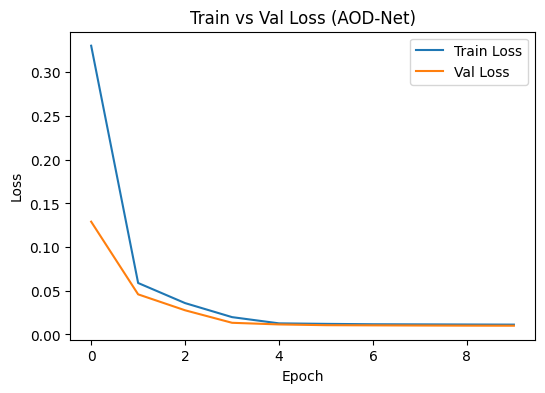

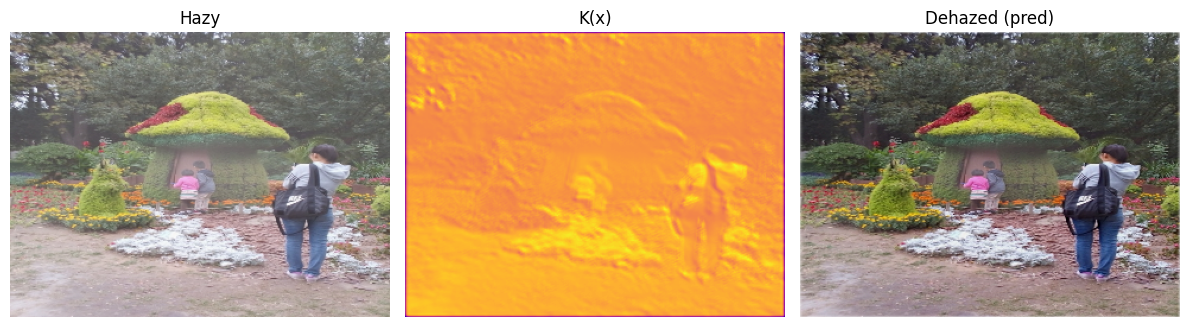

In [1]:
def main():
    # --- paths (adapt as needed) ---
    hazy_dir = "/kaggle/input/outdoor-training-set-ots-reside/hazy"
    trans_dir = "/kaggle/input/transdata/depth/depth/depth"  
    clear_dirs_to_try = [
        "/kaggle/input/outdoor-training-set-ots-reside/clear",
        "/kaggle/input/outdoor-training-set-ots-reside/gt",
        "/kaggle/input/outdoor-training-set-ots-reside/clear_images",
        hazy_dir  
    ]

    mat_files = sorted(glob.glob(os.path.join(trans_dir, "*.mat")))
    print(f"Found {len(mat_files)} mat files (depth/trans).")

    imgs_hazy, imgs_clear = [], []
    max_samples = 1000  
    collected = 0

    for mat_path in mat_files:
        base = os.path.splitext(os.path.basename(mat_path))[0]

        hazy_imgs = sorted(glob.glob(os.path.join(hazy_dir, f"{base}_*.jpg")))
        if not hazy_imgs:
            hazy_imgs = sorted(glob.glob(os.path.join(hazy_dir, f"{base}*.jpg")))
        if not hazy_imgs:
            continue

        clear_path = None
        candidates = []
        for cd in clear_dirs_to_try:
            if cd is None:
                continue
            patterns = [
                os.path.join(cd, base + ".jpg"),
                os.path.join(cd, base + ".png"),
                os.path.join(cd, base + "_clear.jpg"),
                os.path.join(cd, base + "_rgb.png"),
                os.path.join(cd, base + "_gt.png"),
                os.path.join(cd, base + "_clean.png"),
                os.path.join(cd, base + "_clean.jpg"),
            ]
            for p in patterns:
                if os.path.exists(p):
                    candidates.append(p)
        possible_next_to_hazy = [
            os.path.join(hazy_dir, base + ".jpg"),
            os.path.join(hazy_dir, base + ".png"),
            os.path.join(hazy_dir, base + "_clear.jpg"),
        ]
        for p in possible_next_to_hazy:
            if os.path.exists(p):
                candidates.append(p)

        if candidates:
            clear_path = candidates[0]  
        else:
            clear_path = None

        with h5py.File(mat_path, 'r') as f:
            key = list(f.keys())[0]
            t = np.array(f[key]).T 
        t = np.clip(t, 1e-4, 1.0)

        for img_path in hazy_imgs:
            # read hazy image
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
            img = cv2.resize(img, (320,240))
            t_resized = cv2.resize(t, (320,240))
            if clear_path is not None and os.path.exists(clear_path):
                clr = cv2.imread(clear_path)
                clr = cv2.cvtColor(clr, cv2.COLOR_BGR2RGB) / 255.0
                clr = cv2.resize(clr, (320,240))
            else:
                def estimate_atmospheric_light(img_local, t_map_local):
                    flat = t_map_local.flatten()
                    top_n = max(int(flat.size * 0.001), 1)
                    indices = np.argpartition(flat, -top_n)[-top_n:]
                    candidates = img_local.reshape(-1,3)[indices]
                    brightness = np.max(candidates, axis=1)
                    A = candidates[np.argmax(brightness)]
                    return A
                A_est = estimate_atmospheric_light(img, t_resized)
                t_clipped = np.clip(t_resized, 1e-4, 1.0)
                J_approx = (img - A_est*(1 - t_clipped[..., None])) / (t_clipped[..., None] + 1e-6)
                clr = np.clip(J_approx, 0.0, 1.0)

            imgs_hazy.append(torch.from_numpy(img).permute(2,0,1).float())
            imgs_clear.append(torch.from_numpy(clr).permute(2,0,1).float())
            collected += 1
            if collected >= max_samples:
                break

        if collected >= max_samples:
            break

    if len(imgs_hazy) == 0:
        raise RuntimeError("No  clear image paths and .mat files.")

    dataset = TensorDataset(torch.stack(imgs_hazy), torch.stack(imgs_clear))
    total = len(dataset)
    train_size = int(0.7 * total)
    val_size = int(0.15 * total)
    test_size = total - train_size - val_size
    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=4)
    test_loader = DataLoader(test_set, batch_size=4)

    # build model
    model = build_aodnet()

    print("Training AOD-Net")
    train_losses, val_losses = train_aodnet(model, train_loader, val_loader, epochs=10, lr=1e-4)

    # save loss curve
    plt.figure(figsize=(6,4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train vs Val Loss (AOD-Net)")
    plt.legend()
    plt.savefig("loss_curve.png", dpi=150)
    print("Saved loss_curve.png")
    torch.save({'aodnet': model.state_dict()}, "aodnet_weights.pth")
    print("Saved model weights to aodnet_weights.pth")

    print("Evaluating on full test set...")
    evaluate_testset(model, test_loader)

    print("Testing on one sample and saving visualization...")
    test_and_show(model, test_loader)


if __name__ == "__main__":
    main()


In [16]:

def test_single_image(model, hazy_path, clear_path=None, save_path="explicit_test.png"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    img = cv2.imread(hazy_path)
    if img is None:
        raise FileNotFoundError(f"No image")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0
    img_resized = cv2.resize(img, (320,240))
    tensor = torch.from_numpy(img_resized).permute(2,0,1).unsqueeze(0).float().to(device)

    with torch.no_grad():
        pred, K = model(tensor)

    pred_np = pred[0].cpu().numpy().transpose(1,2,0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img_resized); plt.title("Input (hazy)"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(np.clip(pred_np,0,1)); plt.title("Dehazed (pred)"); plt.axis("off")

    metrics = {}
    if clear_path is not None and os.path.exists(clear_path):
        gt = cv2.imread(clear_path)
        gt = cv2.cvtColor(gt, cv2.COLOR_BGR2RGB) / 255.0
        h, w = pred_np.shape[:2]
        gt_resized = cv2.resize(gt, (w, h))  

        plt.subplot(1,3,3); plt.imshow(gt_resized); plt.title("Ground-truth"); plt.axis("off")

        gt_uint = (np.clip(gt_resized,0,1)*255).astype(np.uint8)
        pred_uint = (np.clip(pred_np,0,1)*255).astype(np.uint8)

        try:
            ssim_val = ssim(gt_uint, pred_uint, channel_axis=-1, data_range=255)
        except:
            ssim_val = ssim(gt_uint, pred_uint, multichannel=True, data_range=255)

        psnr_val = compute_psnr(gt_resized, pred_np, data_range=1.0)
        mae_val = np.mean(np.abs(gt_resized - pred_np))

        metrics = {"SSIM": ssim_val, "PSNR": psnr_val, "MAE": mae_val}
        print(f"Single test metrics - SSIM: {ssim_val:.4f}, PSNR: {psnr_val:.2f}, MAE: {mae_val:.4f}")

    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    print(f"Saved test result to {save_path}")

    return metrics


✅ Saved explicit test result to explicit_test.png
✅ Saved explicit test result to /kaggle/working/explicit_case.png


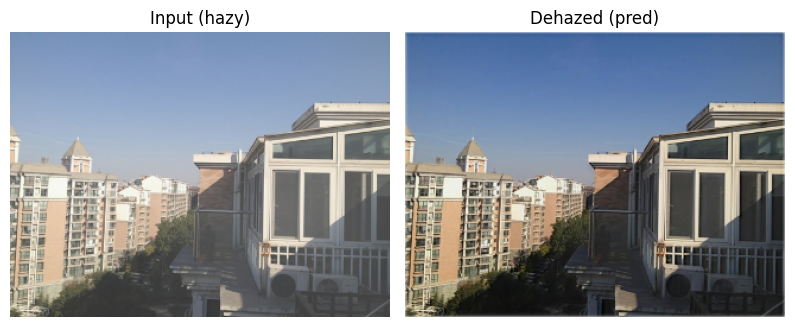

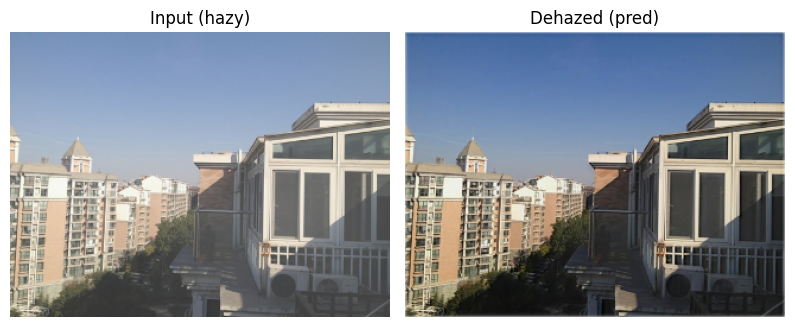

In [17]:

model = build_aodnet()
model.load_state_dict(torch.load("aodnet_weights.pth")['aodnet'])

test_single_image(model, "/kaggle/input/outdoor-training-set-ots-reside/hazy/0138_0.9_0.1.jpg")
metrics = test_single_image(
    model,
    hazy_path="/kaggle/input/outdoor-training-set-ots-reside/hazy/0138_0.9_0.1.jpg",
    clear_path="/kaggle/input/outdoor-training-set-ots-reside/hazy/0138.jpg",
    save_path="/kaggle/working/explicit_case.png"
)


In [29]:
img1 = cv2.imread("/kaggle/working/explicit_case.png")
img2 = cv2.imread("/kaggle/input/outdoor-training-set-ots-reside/hazy/0138_0.9_0.1.jpg")

In [30]:
h, w = img2.shape[:2]   # predicted image size
img1_resized = cv2.resize(img1, (w, h))  # resize GT to match prediction
psnr_val = compute_psnr(img1_resized, img2, data_range=255.0)


In [31]:
psnr_val

27.970903973085782

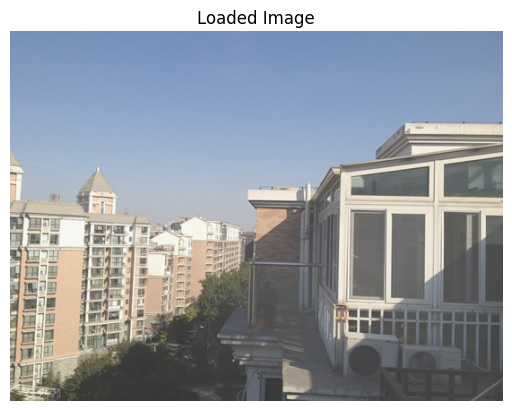

Image shape: (413, 550, 3)


In [2]:
import cv2
import matplotlib.pyplot as plt

image_path = "/kaggle/input/outdoor-training-set-ots-reside/hazy/0138_0.9_0.1.jpg"   # change this to your image path

img_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)

if img_bgr is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

plt.imshow(img_rgb)
plt.axis("off")
plt.title("Loaded Image")
plt.show()

print("Image shape:", img_rgb.shape)
